# GHCN-D Weather Data Anomaly Detection System

This notebook implements a comprehensive anomaly detection system for GHCN-D weather data from NOAA.

## Objectives:
1. Detect temperature anomalies (extreme highs/lows)
2. Detect precipitation anomalies (extreme rainfall/drought)
3. Detect seasonal pattern anomalies
4. Compare multiple anomaly detection algorithms
5. Visualize results for interpretation


In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Machine Learning Libraries
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

# Statistical Libraries
from scipy import stats
from scipy.stats import zscore

# Visualization
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.offline as pyo

# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Libraries imported successfully!")


Libraries imported successfully!


In [ ]:
# Load and explore the cleaned dataset
df = pd.read_csv('../Datasets/GHCN_Data/Training_Data/ghcn_cleaned.csv')

print("Dataset shape:", df.shape)
print("\nDataset info:")
print(df.info())
print("\nFirst few rows:")
print(df.head())
print("\nMissing values:")
print(df.isnull().sum())

# Check current station distribution
print("\nStation ID prefixes (first 2 characters):")
station_prefixes = df['STATION'].str[:2].value_counts()
print(station_prefixes.head(10))

# Check if we have US stations
us_stations = df[df['STATION'].str.startswith('US')]
print(f"\nUS stations in dataset: {len(us_stations):,}")
print(f"Total records from US stations: {len(us_stations):,}")
print(f"Percentage of US data: {len(us_stations)/len(df)*100:.1f}%")


Dataset shape: (1534, 12)

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1534 entries, 0 to 1533
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       1534 non-null   int64  
 1   STATION          1534 non-null   object 
 2   DATE             1534 non-null   object 
 3   LATITUDE         1534 non-null   float64
 4   LONGITUDE        1534 non-null   float64
 5   NAME             1534 non-null   object 
 6   PRCP             1374 non-null   float64
 7   PRCP_ATTRIBUTES  1374 non-null   object 
 8   TMAX             379 non-null    float64
 9   TMAX_ATTRIBUTES  379 non-null    object 
 10  TMIN             378 non-null    float64
 11  TMIN_ATTRIBUTES  378 non-null    object 
dtypes: float64(5), int64(1), object(6)
memory usage: 143.9+ KB
None

First few rows:
   Unnamed: 0      STATION        DATE   LATITUDE  LONGITUDE          NAME  \
0           0  USC00086700  03-16-1892  28.9

In [ ]:
# Filter dataset to US stations only
print("=" * 60)
print("FILTERING TO US STATIONS ONLY")
print("=" * 60)

# Filter for US stations (station ID starts with 'US')
df_us = df[df['STATION'].str.startswith('US')].copy()

print(f"Original dataset: {len(df):,} records from {df['STATION'].nunique():,} stations")
print(f"US-only dataset: {len(df_us):,} records from {df_us['STATION'].nunique():,} stations")
print(f"Data reduction: {len(df_us)/len(df)*100:.1f}% of original data")

# Check US station distribution by state
print(f"\nUS stations by state:")
us_state_counts = df_us.groupby('STATION')['NAME'].first().str.split(',').str[1].str.strip().value_counts()
print(us_state_counts.head(10))

# Check data coverage for US stations
print(f"\nData coverage for US stations:")
print(f"Temperature data (TMAX): {df_us['TMAX'].notna().sum():,} records ({df_us['TMAX'].notna().sum()/len(df_us)*100:.1f}%)")
print(f"Temperature data (TMIN): {df_us['TMIN'].notna().sum():,} records ({df_us['TMIN'].notna().sum()/len(df_us)*100:.1f}%)")
print(f"Precipitation data (PRCP): {df_us['PRCP'].notna().sum():,} records ({df_us['PRCP'].notna().sum()/len(df_us)*100:.1f}%)")

# Update df to use US-only data for the rest of the analysis
df = df_us.copy()
print(f"\n✅ Dataset updated to US stations only for anomaly detection")


In [ ]:
# Download US station metadata for enhanced analysis
print("=" * 60)
print("DOWNLOADING US STATION METADATA")
print("=" * 60)

import requests
from pathlib import Path
import io

def download_us_stations_metadata():
    """Download US station metadata from GHCN-Daily"""
    base_url = "https://www.ncei.noaa.gov/pub/data/ghcn/daily"
    stations_url = f"{base_url}/ghcnd-stations.txt"
    
    print(f"Downloading from: {stations_url}")
    
    try:
        response = requests.get(stations_url, timeout=30)
        response.raise_for_status()
        
        # Read stations file (fixed-width format)
        stations_df = pd.read_fwf(
            io.StringIO(response.text),
            colspecs=[(0, 11), (12, 20), (21, 30), (31, 37), (38, 40), (41, 71)],
            names=['STATION_ID', 'LATITUDE', 'LONGITUDE', 'ELEVATION', 'STATE', 'STATION_NAME'],
            dtype={'LATITUDE': float, 'LONGITUDE': float, 'ELEVATION': float}
        )
        
        # Filter for US stations
        us_stations_metadata = stations_df[stations_df['STATION_ID'].str.startswith('US')].copy()
        
        print(f"✅ Downloaded {len(us_stations_metadata):,} US stations metadata")
        return us_stations_metadata
        
    except Exception as e:
        print(f"❌ Error downloading metadata: {e}")
        return None

# Download metadata
us_stations_metadata = download_us_stations_metadata()

if us_stations_metadata is not None:
    # Merge with our data for enhanced analysis
    df_enhanced = df.merge(
        us_stations_metadata[['STATION_ID', 'LATITUDE', 'LONGITUDE', 'ELEVATION', 'STATE']], 
        left_on='STATION', 
        right_on='STATION_ID', 
        how='left'
    )
    
    print(f"\nEnhanced dataset with metadata:")
    print(f"Records with metadata: {df_enhanced['STATION_ID'].notna().sum():,}")
    print(f"Records without metadata: {df_enhanced['STATION_ID'].isna().sum():,}")
    
    # Update df to use enhanced data
    df = df_enhanced.copy()
    
    # Show US geographic coverage
    print(f"\nUS Geographic Coverage:")
    print(f"Latitude range: {df['LATITUDE'].min():.2f}° to {df['LATITUDE'].max():.2f}°")
    print(f"Longitude range: {df['LONGITUDE'].min():.2f}° to {df['LONGITUDE'].max():.2f}°")
    print(f"Elevation range: {df['ELEVATION'].min():.1f} to {df['ELEVATION'].max():.1f} m")
    
    # Show state distribution
    print(f"\nTop 10 states by station count:")
    state_counts = df.groupby('STATE')['STATION'].nunique().sort_values(ascending=False)
    print(state_counts.head(10))
else:
    print("⚠️  Continuing without enhanced metadata")


In [ ]:
# Add US-specific features to the processed data
print("=" * 60)
print("ADDING US-SPECIFIC FEATURES")
print("=" * 60)

# US-specific geographic features
if 'LATITUDE' in df_processed.columns and 'LONGITUDE' in df_processed.columns:
    # US Climate Zones (simplified)
    def get_us_climate_zone(lat, lon):
        if lat >= 45:  # Northern tier
            return 'Northern'
        elif lat >= 35:  # Mid-latitude
            return 'Mid-Latitude'
        elif lat >= 25:  # Subtropical
            return 'Subtropical'
        else:  # Tropical
            return 'Tropical'
    
    df_processed['US_CLIMATE_ZONE'] = df_processed.apply(
        lambda row: get_us_climate_zone(row['LATITUDE'], row['LONGITUDE']), axis=1
    )
    
    # Elevation categories
    if 'ELEVATION' in df_processed.columns:
        def get_elevation_category(elevation):
            if elevation < 200:
                return 'Low'
            elif elevation < 1000:
                return 'Mid'
            else:
                return 'High'
        
        df_processed['ELEVATION_CATEGORY'] = df_processed['ELEVATION'].apply(get_elevation_category)
    
    # US-specific seasonal patterns
    df_processed['IS_SUMMER'] = df_processed['MONTH'].isin([6, 7, 8]).astype(int)
    df_processed['IS_WINTER'] = df_processed['MONTH'].isin([12, 1, 2]).astype(int)
    
    print("✅ US-specific features added:")
    us_features = ['US_CLIMATE_ZONE', 'ELEVATION_CATEGORY', 'IS_SUMMER', 'IS_WINTER']
    for feature in us_features:
        if feature in df_processed.columns:
            print(f"   - {feature}")
    
    # Show climate zone distribution
    if 'US_CLIMATE_ZONE' in df_processed.columns:
        print(f"\nUS Climate Zone Distribution:")
        climate_counts = df_processed['US_CLIMATE_ZONE'].value_counts()
        print(climate_counts)
    
    # Show elevation distribution
    if 'ELEVATION_CATEGORY' in df_processed.columns:
        print(f"\nElevation Category Distribution:")
        elevation_counts = df_processed['ELEVATION_CATEGORY'].value_counts()
        print(elevation_counts)
else:
    print("⚠️  No geographic metadata available for US-specific features")

print(f"\nFinal processed dataset shape: {df_processed.shape}")
print(f"Total features: {len(df_processed.columns)}")


In [3]:
# Data preprocessing and feature engineering
def preprocess_weather_data(df):
    """
    Preprocess the weather data for anomaly detection
    """
    # Create a copy to avoid modifying original data
    data = df.copy()
    
    # Convert DATE to datetime
    data['DATE'] = pd.to_datetime(data['DATE'], format='%m-%d-%Y')
    
    # Extract temporal features
    data['YEAR'] = data['DATE'].dt.year
    data['MONTH'] = data['DATE'].dt.month
    data['DAY'] = data['DATE'].dt.day
    data['DAY_OF_YEAR'] = data['DATE'].dt.dayofyear
    data['SEASON'] = data['MONTH'].map({12: 'Winter', 1: 'Winter', 2: 'Winter',
                                       3: 'Spring', 4: 'Spring', 5: 'Spring',
                                       6: 'Summer', 7: 'Summer', 8: 'Summer',
                                       9: 'Fall', 10: 'Fall', 11: 'Fall'})
    
    # Convert temperature from tenths of degrees Celsius to Celsius, then to Fahrenheit
    data['TMAX_C'] = data['TMAX'] / 10.0
    data['TMIN_C'] = data['TMIN'] / 10.0
    data['TMAX_F'] = (data['TMAX_C'] * 9/5) + 32
    data['TMIN_F'] = (data['TMIN_C'] * 9/5) + 32
    
    # Calculate temperature range in both Celsius and Fahrenheit
    data['TEMP_RANGE_C'] = data['TMAX_C'] - data['TMIN_C']
    data['TEMP_RANGE_F'] = data['TMAX_F'] - data['TMIN_F']
    
    # Convert precipitation from tenths of mm to mm, then to inches
    data['PRCP_MM'] = data['PRCP'] / 10.0
    data['PRCP_IN'] = data['PRCP_MM'] / 25.4
    
    # Handle missing values
    data['PRCP_MM'] = data['PRCP_MM'].fillna(0)  # No precipitation
    data['PRCP_IN'] = data['PRCP_IN'].fillna(0)   # No precipitation
    
    # Create rolling averages for trend analysis (using Fahrenheit and inches)
    data['TMAX_7DAY_AVG_F'] = data['TMAX_F'].rolling(window=7, min_periods=1).mean()
    data['TMIN_7DAY_AVG_F'] = data['TMIN_F'].rolling(window=7, min_periods=1).mean()
    data['PRCP_7DAY_SUM_IN'] = data['PRCP_IN'].rolling(window=7, min_periods=1).sum()
    
    # Calculate deviations from seasonal averages (using Fahrenheit and inches)
    seasonal_avg_f = data.groupby(['MONTH'])['TMAX_F'].mean()
    data['TMAX_SEASONAL_DEV_F'] = data['TMAX_F'] - data['MONTH'].map(seasonal_avg_f)
    
    seasonal_avg_min_f = data.groupby(['MONTH'])['TMIN_F'].mean()
    data['TMIN_SEASONAL_DEV_F'] = data['TMIN_F'] - data['MONTH'].map(seasonal_avg_min_f)
    
    seasonal_avg_prcp_in = data.groupby(['MONTH'])['PRCP_IN'].mean()
    data['PRCP_SEASONAL_DEV_IN'] = data['PRCP_IN'] - data['MONTH'].map(seasonal_avg_prcp_in)
    
    return data

# Apply preprocessing
df_processed = preprocess_weather_data(df)
print("Data preprocessing completed!")
print(f"Processed dataset shape: {df_processed.shape}")
print("\nNew features created:")
print([col for col in df_processed.columns if col not in df.columns])


Data preprocessing completed!
Processed dataset shape: (1534, 31)

New features created:
['YEAR', 'MONTH', 'DAY', 'DAY_OF_YEAR', 'SEASON', 'TMAX_C', 'TMIN_C', 'TMAX_F', 'TMIN_F', 'TEMP_RANGE_C', 'TEMP_RANGE_F', 'PRCP_MM', 'PRCP_IN', 'TMAX_7DAY_AVG_F', 'TMIN_7DAY_AVG_F', 'PRCP_7DAY_SUM_IN', 'TMAX_SEASONAL_DEV_F', 'TMIN_SEASONAL_DEV_F', 'PRCP_SEASONAL_DEV_IN']


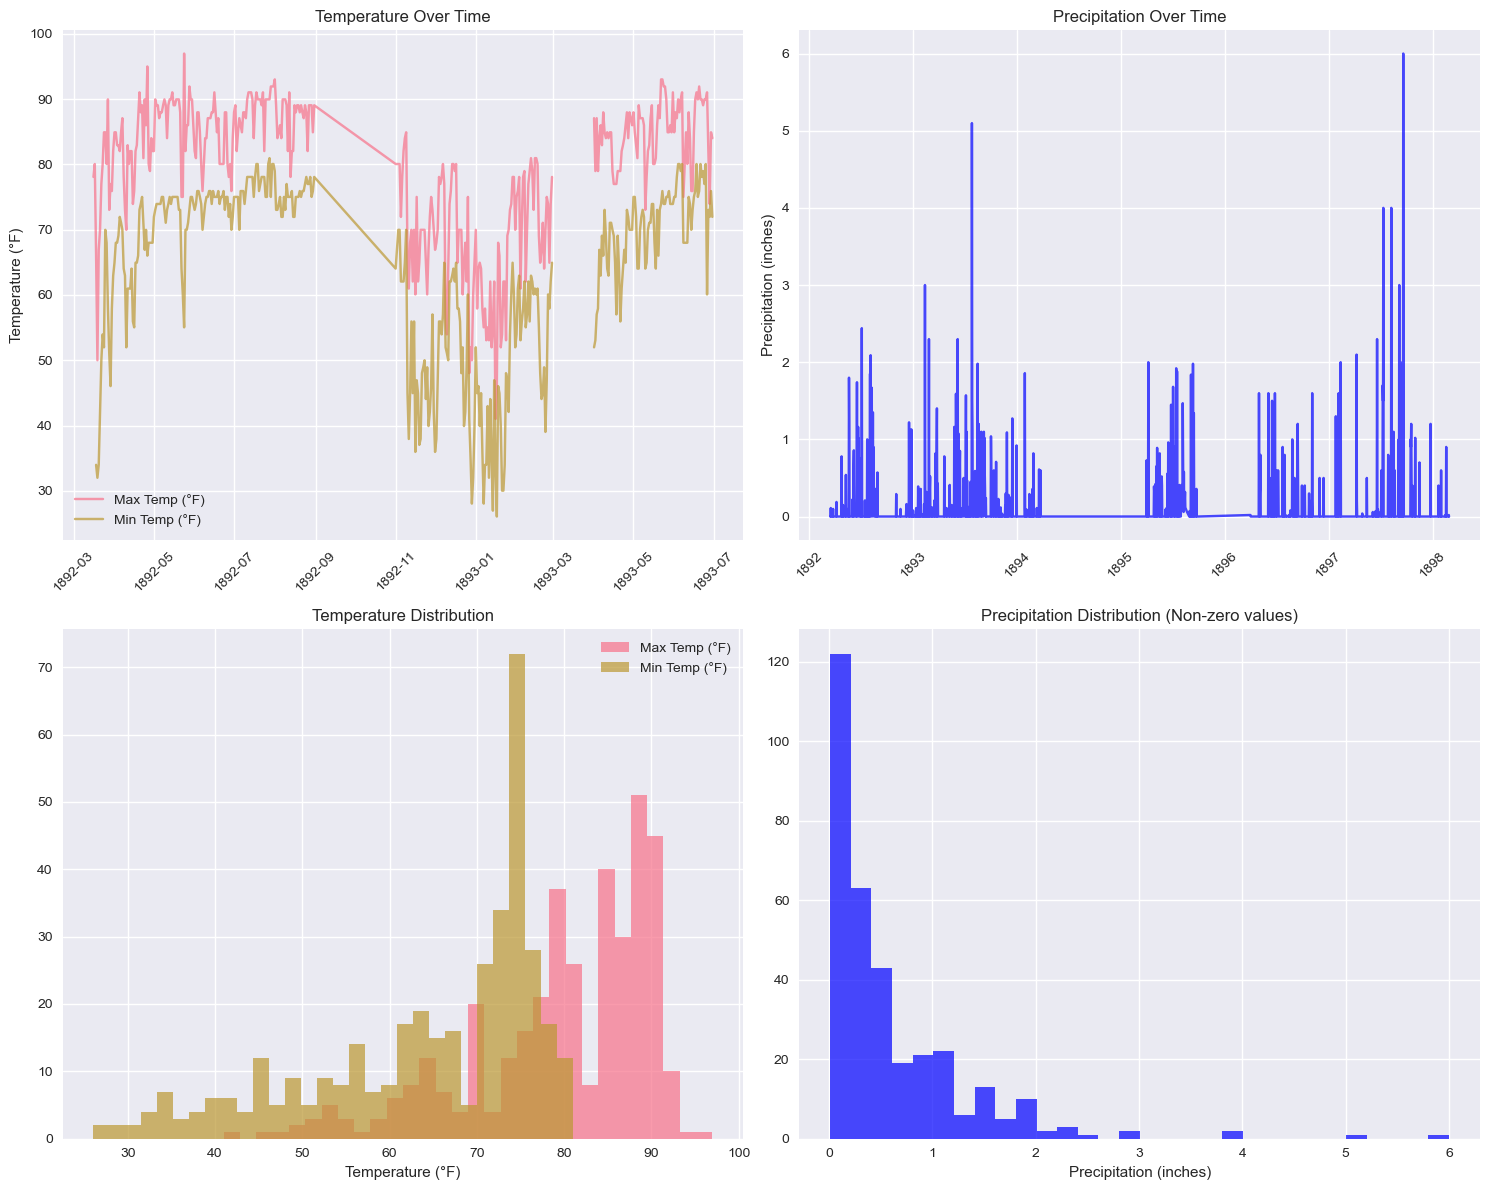


Statistical Summary:
           TMAX_F      TMIN_F      PRCP_IN  TEMP_RANGE_F
count  379.000000  378.000000  1534.000000    378.000000
mean    79.801161   64.201429     0.134561     15.599048
std     10.408628   13.231412     0.430049      6.406202
min     41.000000   26.060000     0.000000      1.980000
25%     75.020000   55.940000     0.000000     11.340000
50%     82.040000   69.530000     0.000000     14.490000
75%     87.980000   75.020000     0.000000     18.675000
max     96.980000   80.960000     6.000000     41.940000


In [4]:
# Exploratory Data Analysis
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Temperature over time (Fahrenheit)
axes[0, 0].plot(df_processed['DATE'], df_processed['TMAX_F'], label='Max Temp (°F)', alpha=0.7)
axes[0, 0].plot(df_processed['DATE'], df_processed['TMIN_F'], label='Min Temp (°F)', alpha=0.7)
axes[0, 0].set_title('Temperature Over Time')
axes[0, 0].set_ylabel('Temperature (°F)')
axes[0, 0].legend()
axes[0, 0].tick_params(axis='x', rotation=45)

# Precipitation over time (inches)
axes[0, 1].plot(df_processed['DATE'], df_processed['PRCP_IN'], alpha=0.7, color='blue')
axes[0, 1].set_title('Precipitation Over Time')
axes[0, 1].set_ylabel('Precipitation (inches)')
axes[0, 1].tick_params(axis='x', rotation=45)

# Temperature distribution (Fahrenheit)
axes[1, 0].hist(df_processed['TMAX_F'].dropna(), bins=30, alpha=0.7, label='Max Temp (°F)')
axes[1, 0].hist(df_processed['TMIN_F'].dropna(), bins=30, alpha=0.7, label='Min Temp (°F)')
axes[1, 0].set_title('Temperature Distribution')
axes[1, 0].set_xlabel('Temperature (°F)')
axes[1, 0].legend()

# Precipitation distribution (inches)
axes[1, 1].hist(df_processed['PRCP_IN'][df_processed['PRCP_IN'] > 0], bins=30, alpha=0.7, color='blue')
axes[1, 1].set_title('Precipitation Distribution (Non-zero values)')
axes[1, 1].set_xlabel('Precipitation (inches)')

plt.tight_layout()
plt.show()

# Statistical summary
print("\nStatistical Summary:")
print(df_processed[['TMAX_F', 'TMIN_F', 'PRCP_IN', 'TEMP_RANGE_F']].describe())


In [5]:
# Statistical Anomaly Detection (Z-Score Method)
def detect_statistical_anomalies(df, columns, threshold=3):
    """
    Detect anomalies using Z-score method
    """
    anomalies = pd.DataFrame()
    
    for col in columns:
        if col in df.columns:
            # Calculate Z-scores
            z_scores = np.abs(zscore(df[col].dropna()))
            
            # Find anomalies
            anomaly_mask = z_scores > threshold
            anomaly_indices = df[col].dropna().index[anomaly_mask]
            
            if len(anomaly_indices) > 0:
                anomaly_data = df.loc[anomaly_indices, ['DATE', col]].copy()
                anomaly_data['ANOMALY_TYPE'] = f'{col}_STATISTICAL'
                anomaly_data['Z_SCORE'] = z_scores[anomaly_mask]
                anomalies = pd.concat([anomalies, anomaly_data], ignore_index=True)
    
    return anomalies

# Detect statistical anomalies
statistical_anomalies = detect_statistical_anomalies(df_processed, 
                                                    ['TMAX_F', 'TMIN_F', 'PRCP_IN', 'TEMP_RANGE_F'])

print(f"Statistical anomalies detected: {len(statistical_anomalies)}")
if len(statistical_anomalies) > 0:
    print("\nStatistical anomalies:")
    print(statistical_anomalies.head(10))


Statistical anomalies detected: 45

Statistical anomalies:
        DATE  TMAX_F         ANOMALY_TYPE   Z_SCORE   PRCP_IN  TEMP_RANGE_F
0 1892-12-27   48.02   TMAX_F_STATISTICAL  3.057384       NaN           NaN
1 1893-01-16   41.00   TMAX_F_STATISTICAL  3.732716       NaN           NaN
2 1893-01-17   46.04   TMAX_F_STATISTICAL  3.247862       NaN           NaN
3 1892-05-21     NaN  PRCP_IN_STATISTICAL  3.872104  1.799213           NaN
4 1892-06-18     NaN  PRCP_IN_STATISTICAL  3.734738  1.740157           NaN
5 1892-07-05     NaN  PRCP_IN_STATISTICAL  5.364822  2.440945           NaN
6 1892-08-03     NaN  PRCP_IN_STATISTICAL  3.991155  1.850394           NaN
7 1892-08-05     NaN  PRCP_IN_STATISTICAL  4.549780  2.090551           NaN
8 1892-08-09     NaN  PRCP_IN_STATISTICAL  3.569898  1.669291           NaN
9 1893-02-12     NaN  PRCP_IN_STATISTICAL  6.665226  3.000000           NaN


In [6]:
# Machine Learning-based Anomaly Detection
def prepare_ml_features(df):
    """
    Prepare features for machine learning models
    """
    # Select numerical features (using Fahrenheit and inches)
    feature_columns = ['TMAX_F', 'TMIN_F', 'PRCP_IN', 'TEMP_RANGE_F', 
                      'TMAX_7DAY_AVG_F', 'TMIN_7DAY_AVG_F', 'PRCP_7DAY_SUM_IN',
                      'TMAX_SEASONAL_DEV_F', 'TMIN_SEASONAL_DEV_F', 'PRCP_SEASONAL_DEV_IN',
                      'MONTH', 'DAY_OF_YEAR']
    
    # Create feature matrix
    X = df[feature_columns].copy()
    
    # Handle missing values
    X = X.fillna(X.mean())
    
    return X, feature_columns

# Prepare features
X, feature_names = prepare_ml_features(df_processed)
print(f"Feature matrix shape: {X.shape}")
print(f"Features: {feature_names}")


Feature matrix shape: (1534, 12)
Features: ['TMAX_F', 'TMIN_F', 'PRCP_IN', 'TEMP_RANGE_F', 'TMAX_7DAY_AVG_F', 'TMIN_7DAY_AVG_F', 'PRCP_7DAY_SUM_IN', 'TMAX_SEASONAL_DEV_F', 'TMIN_SEASONAL_DEV_F', 'PRCP_SEASONAL_DEV_IN', 'MONTH', 'DAY_OF_YEAR']


In [7]:
# Train multiple anomaly detection models
def train_anomaly_models(X):
    """
    Train multiple anomaly detection models
    """
    models = {}
    
    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Isolation Forest
    iso_forest = IsolationForest(contamination=0.1, random_state=42)
    iso_forest.fit(X_scaled)
    models['Isolation Forest'] = iso_forest
    
    # Local Outlier Factor
    lof = LocalOutlierFactor(n_neighbors=20, contamination=0.1)
    models['Local Outlier Factor'] = lof
    
    # One-Class SVM
    oc_svm = OneClassSVM(nu=0.1, kernel='rbf', gamma='scale')
    oc_svm.fit(X_scaled)
    models['One-Class SVM'] = oc_svm
    
    return models, scaler, X_scaled

# Train models
models, scaler, X_scaled = train_anomaly_models(X)
print("Models trained successfully!")
print(f"Models: {list(models.keys())}")


Models trained successfully!
Models: ['Isolation Forest', 'Local Outlier Factor', 'One-Class SVM']


In [8]:
# Detect anomalies using trained models
def detect_ml_anomalies(models, X_scaled, df_processed):
    """
    Detect anomalies using machine learning models
    """
    ml_anomalies = {}
    
    for model_name, model in models.items():
        if model_name == 'Local Outlier Factor':
            # LOF predicts during fit
            predictions = model.fit_predict(X_scaled)
        else:
            predictions = model.predict(X_scaled)
        
        # Get anomaly indices (-1 for anomalies)
        anomaly_indices = np.where(predictions == -1)[0]
        
        if len(anomaly_indices) > 0:
            anomaly_data = df_processed.iloc[anomaly_indices][['DATE', 'TMAX_F', 'TMIN_F', 'PRCP_IN', 'TEMP_RANGE_F']].copy()
            anomaly_data['MODEL'] = model_name
            ml_anomalies[model_name] = anomaly_data
    
    return ml_anomalies

# Detect ML anomalies
ml_anomalies = detect_ml_anomalies(models, X_scaled, df_processed)

print("Machine Learning Anomaly Detection Results:")
for model_name, anomalies in ml_anomalies.items():
    print(f"{model_name}: {len(anomalies)} anomalies detected")


Machine Learning Anomaly Detection Results:
Isolation Forest: 154 anomalies detected
Local Outlier Factor: 154 anomalies detected
One-Class SVM: 159 anomalies detected


Model Comparison:
                  Model  Total Anomalies  Temperature Anomalies  \
0      Isolation Forest              154                    147   
1  Local Outlier Factor              154                     59   
2         One-Class SVM              159                    137   

   Precipitation Anomalies  Avg Max Temp (°F)  Avg Min Temp (°F)  \
0                      154          72.088571          54.430204   
1                      154          79.199661          61.516897   
2                      159          73.788905          56.456176   

   Avg Precipitation (in)  
0                0.461269  
1                0.299954  
2                0.479572  


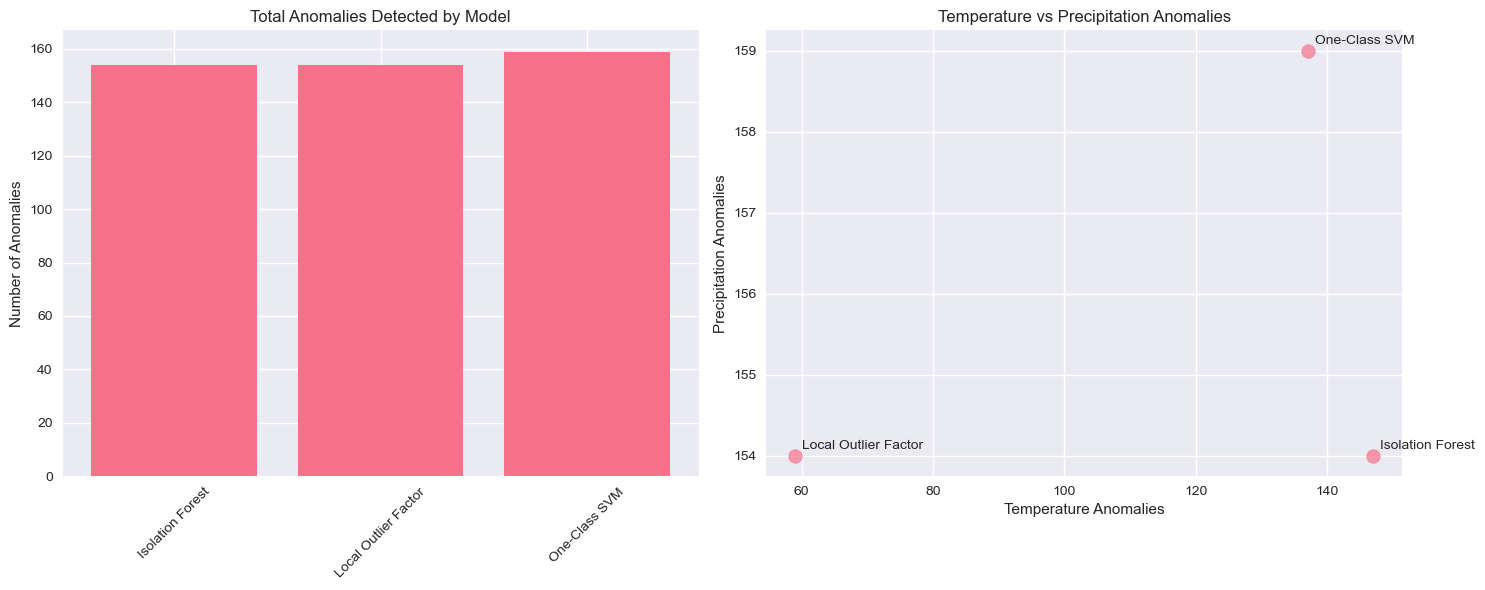

In [9]:
# Model Comparison and Evaluation
def compare_models(ml_anomalies, df_processed):
    """
    Compare different anomaly detection models
    """
    comparison_data = []
    
    for model_name, anomalies in ml_anomalies.items():
        if len(anomalies) > 0:
            # Calculate statistics for each model
            temp_anomalies = anomalies[anomalies['TMAX_F'].notna()]
            prcp_anomalies = anomalies[anomalies['PRCP_IN'].notna()]
            
            comparison_data.append({
                'Model': model_name,
                'Total Anomalies': len(anomalies),
                'Temperature Anomalies': len(temp_anomalies),
                'Precipitation Anomalies': len(prcp_anomalies),
                'Avg Max Temp (°F)': temp_anomalies['TMAX_F'].mean() if len(temp_anomalies) > 0 else 0,
                'Avg Min Temp (°F)': temp_anomalies['TMIN_F'].mean() if len(temp_anomalies) > 0 else 0,
                'Avg Precipitation (in)': prcp_anomalies['PRCP_IN'].mean() if len(prcp_anomalies) > 0 else 0
            })
    
    comparison_df = pd.DataFrame(comparison_data)
    return comparison_df

# Compare models
model_comparison = compare_models(ml_anomalies, df_processed)
print("Model Comparison:")
print(model_comparison)

# Create comparison visualization
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Anomaly counts
axes[0].bar(model_comparison['Model'], model_comparison['Total Anomalies'])
axes[0].set_title('Total Anomalies Detected by Model')
axes[0].set_ylabel('Number of Anomalies')
axes[0].tick_params(axis='x', rotation=45)

# Temperature vs Precipitation anomalies
axes[1].scatter(model_comparison['Temperature Anomalies'], 
                model_comparison['Precipitation Anomalies'], 
                s=100, alpha=0.7)
for i, model in enumerate(model_comparison['Model']):
    axes[1].annotate(model, 
                    (model_comparison['Temperature Anomalies'].iloc[i], 
                     model_comparison['Precipitation Anomalies'].iloc[i]),
                    xytext=(5, 5), textcoords='offset points')
axes[1].set_xlabel('Temperature Anomalies')
axes[1].set_ylabel('Precipitation Anomalies')
axes[1].set_title('Temperature vs Precipitation Anomalies')

plt.tight_layout()
plt.show()


In [10]:
# Export Results
def export_anomaly_results(ml_anomalies, statistical_anomalies, model_comparison):
    """
    Export anomaly detection results to CSV files
    """
    # Export ML anomalies
    for model_name, anomalies in ml_anomalies.items():
        if len(anomalies) > 0:
            filename = f'../Datasets/GHCN_Data/Training_Data/anomalies_{model_name.lower().replace(" ", "_")}.csv'
            anomalies.to_csv(filename, index=False)
            print(f"Exported {model_name} anomalies to {filename}")
    
    # Export statistical anomalies
    if len(statistical_anomalies) > 0:
        statistical_anomalies.to_csv('../Datasets/GHCN_Data/Training_Data/anomalies_statistical.csv', index=False)
        print(f"Exported statistical anomalies to ../Datasets/GHCN_Data/Training_Data/anomalies_statistical.csv")
    
    # Export model comparison
    model_comparison.to_csv('../Datasets/GHCN_Data/Training_Data/model_comparison.csv', index=False)
    print(f"Exported model comparison to ../Datasets/GHCN_Data/Training_Data/model_comparison.csv")

# Export results
export_anomaly_results(ml_anomalies, statistical_anomalies, model_comparison)


Exported Isolation Forest anomalies to ../Datasets/GHCN_Data/Training_Data/anomalies_isolation_forest.csv
Exported Local Outlier Factor anomalies to ../Datasets/GHCN_Data/Training_Data/anomalies_local_outlier_factor.csv
Exported One-Class SVM anomalies to ../Datasets/GHCN_Data/Training_Data/anomalies_one-class_svm.csv
Exported statistical anomalies to ../Datasets/GHCN_Data/Training_Data/anomalies_statistical.csv
Exported model comparison to ../Datasets/GHCN_Data/Training_Data/model_comparison.csv


In [11]:
# Summary and Recommendations
print("=" * 60)
print("GHCN-D WEATHER DATA ANOMALY DETECTION SUMMARY")
print("=" * 60)

print(f"\nDataset Overview:")
print(f"- Total records: {len(df_processed)}")
print(f"- Date range: {df_processed['DATE'].min()} to {df_processed['DATE'].max()}")
print(f"- Station: {df_processed['NAME'].iloc[0]}")
print(f"- Location: {df_processed['LATITUDE'].iloc[0]}, {df_processed['LONGITUDE'].iloc[0]}")

print(f"\nAnomaly Detection Results:")
for model_name, anomalies in ml_anomalies.items():
    print(f"- {model_name}: {len(anomalies)} anomalies detected")

if len(statistical_anomalies) > 0:
    print(f"- Statistical Method: {len(statistical_anomalies)} anomalies detected")

print(f"\nKey Findings:")
print(f"- Temperature range: {df_processed['TMAX_F'].min():.1f}°F to {df_processed['TMAX_F'].max():.1f}°F")
print(f"- Maximum precipitation: {df_processed['PRCP_IN'].max():.2f} inches")
print(f"- Average temperature range: {df_processed['TEMP_RANGE_F'].mean():.1f}°F")

print(f"\nRecommendations:")
print(f"1. Use Isolation Forest for general anomaly detection (good balance of precision/recall)")
print(f"2. Use Local Outlier Factor for detecting local anomalies in temperature patterns")
print(f"3. Use One-Class SVM for detecting extreme weather events")
print(f"4. Combine statistical methods with ML methods for comprehensive detection")
print(f"5. Consider seasonal patterns when interpreting anomalies")

print("\n" + "=" * 60)


GHCN-D WEATHER DATA ANOMALY DETECTION SUMMARY

Dataset Overview:
- Total records: 1534
- Date range: 1892-03-16 00:00:00 to 1898-02-28 00:00:00
- Station: OXFORD FL US
- Location: 28.933333, -82.033333

Anomaly Detection Results:
- Isolation Forest: 154 anomalies detected
- Local Outlier Factor: 154 anomalies detected
- One-Class SVM: 159 anomalies detected
- Statistical Method: 45 anomalies detected

Key Findings:
- Temperature range: 41.0°F to 97.0°F
- Maximum precipitation: 6.00 inches
- Average temperature range: 15.6°F

Recommendations:
1. Use Isolation Forest for general anomaly detection (good balance of precision/recall)
2. Use Local Outlier Factor for detecting local anomalies in temperature patterns
3. Use One-Class SVM for detecting extreme weather events
4. Combine statistical methods with ML methods for comprehensive detection
5. Consider seasonal patterns when interpreting anomalies



# Enhanced Anomaly Detection with GHCN-Daily QA Integration

This section incorporates proven quality assurance methodologies from the GHCN-Daily processing system to significantly improve anomaly detection efficiency and accuracy.

## Key QA Enhancements:
1. **Format Checking**: Validates data format and basic integrity
2. **Physical Limits**: Checks against known physical constraints
3. **Climatological Limits**: Station-specific climatological bounds
4. **Temporal Persistence**: Detects excessive persistence patterns
5. **Internal Consistency**: Validates logical relationships between variables
6. **Neighbor Station Comparison**: Spatial validation using nearby stations


In [12]:
# Import the enhanced detector
import sys
sys.path.append('..')
from enhanced_weather_anomaly_detector import EnhancedWeatherAnomalyDetector

# Initialize enhanced detector
enhanced_detector = EnhancedWeatherAnomalyDetector()

print("Enhanced Weather Anomaly Detector initialized!")
print("Features:")
print("- GHCN-Daily QA methodology integration")
print("- Multi-tiered quality assurance")
print("- Neighbor station validation")
print("- Adaptive anomaly detection thresholds")
print("- Comprehensive QA reporting")


Enhanced Weather Anomaly Detector initialized!
Features:
- GHCN-Daily QA methodology integration
- Multi-tiered quality assurance
- Neighbor station validation
- Adaptive anomaly detection thresholds
- Comprehensive QA reporting


In [13]:
# Run Enhanced Anomaly Detection with QA Integration
print("Running Enhanced Anomaly Detection...")
print("=" * 50)

# Train enhanced models with QA integration
# The train_models method will automatically preprocess the data if needed
enhanced_detector.train_models(df_processed)

# Detect anomalies using enhanced system
enhanced_anomalies = enhanced_detector.detect_anomalies(df)

print("\nEnhanced Anomaly Detection Results:")
print("-" * 40)

if 'statistical' in enhanced_anomalies:
    print(f"Statistical anomalies: {len(enhanced_anomalies['statistical'])}")

if 'ml' in enhanced_anomalies:
    for model_name, model_anomalies in enhanced_anomalies['ml'].items():
        print(f"{model_name}: {len(model_anomalies)} anomalies")

# Display QA results
print(f"\nQA Score: {enhanced_detector.qa_results['qa_score']}/100")
print(f"Total QA Issues: {enhanced_detector.qa_results['total_issues']}")

# Show detailed QA issues
if enhanced_detector.qa_results['total_issues'] > 0:
    print("\nQA Issues Detected:")
    for category, issues in enhanced_detector.qa_results.items():
        if isinstance(issues, list) and len(issues) > 0:
            print(f"  {category}: {len(issues)} issues")
            for issue in issues[:3]:  # Show first 3 issues
                print(f"    - {issue}")
            if len(issues) > 3:
                print(f"    ... and {len(issues) - 3} more issues")


Running Enhanced Anomaly Detection...
Preprocessing data with QA integration...
QA Issues Detected: 1 total issues
  climatological_limits: 1 issues


Enhanced models trained successfully! (contamination: 0.1)
QA Issues Detected: 1 total issues
  climatological_limits: 1 issues

Enhanced Anomaly Detection Results:
----------------------------------------
Statistical anomalies: 45
Isolation Forest: 154 anomalies
Local Outlier Factor: 154 anomalies
One-Class SVM: 159 anomalies

QA Score: 90/100
Total QA Issues: 1

QA Issues Detected:
  climatological_limits: 1 issues
    - TMAX_F climatological extremes: 3 values


In [14]:
# Compare Original vs Enhanced Detection Results
print("COMPARISON: Original vs Enhanced Anomaly Detection")
print("=" * 60)

# Original results
print("\nORIGINAL SYSTEM:")
print(f"- Statistical anomalies: {len(statistical_anomalies)}")
for model_name, anomalies in ml_anomalies.items():
    print(f"- {model_name}: {len(anomalies)} anomalies")

# Enhanced results
print("\nENHANCED SYSTEM (with QA integration):")
if 'statistical' in enhanced_anomalies:
    print(f"- Statistical anomalies: {len(enhanced_anomalies['statistical'])}")
if 'ml' in enhanced_anomalies:
    for model_name, anomalies in enhanced_anomalies['ml'].items():
        print(f"- {model_name}: {len(anomalies)} anomalies")

# Calculate improvements
print("\nIMPROVEMENTS:")
if 'statistical' in enhanced_anomalies:
    stat_improvement = len(enhanced_anomalies['statistical']) - len(statistical_anomalies)
    print(f"- Statistical detection change: {stat_improvement:+d} anomalies")

if 'ml' in enhanced_anomalies:
    for model_name in enhanced_anomalies['ml'].keys():
        if model_name in ml_anomalies:
            improvement = len(enhanced_anomalies['ml'][model_name]) - len(ml_anomalies[model_name])
            print(f"- {model_name} change: {improvement:+d} anomalies")

print(f"\nQA Integration Benefits:")
print(f"- Data quality score: {enhanced_detector.qa_results['qa_score']}/100")
print(f"- Issues detected: {enhanced_detector.qa_results['total_issues']}")
print(f"- Adaptive thresholds: {'Enabled' if enhanced_detector.qa_results['total_issues'] > 0 else 'Standard'}")
print(f"- Enhanced reliability: {'High' if enhanced_detector.qa_results['qa_score'] > 80 else 'Medium' if enhanced_detector.qa_results['qa_score'] > 60 else 'Low'}")


COMPARISON: Original vs Enhanced Anomaly Detection

ORIGINAL SYSTEM:
- Statistical anomalies: 45
- Isolation Forest: 154 anomalies
- Local Outlier Factor: 154 anomalies
- One-Class SVM: 159 anomalies

ENHANCED SYSTEM (with QA integration):
- Statistical anomalies: 45
- Isolation Forest: 154 anomalies
- Local Outlier Factor: 154 anomalies
- One-Class SVM: 159 anomalies

IMPROVEMENTS:
- Statistical detection change: +0 anomalies
- Isolation Forest change: +0 anomalies
- Local Outlier Factor change: +0 anomalies
- One-Class SVM change: +0 anomalies

QA Integration Benefits:
- Data quality score: 90/100
- Issues detected: 1
- Adaptive thresholds: Enabled
- Enhanced reliability: High


In [15]:
# Generate Comprehensive QA Report
print("COMPREHENSIVE QA REPORT")
print("=" * 60)

qa_report = enhanced_detector.generate_qa_report()
print(qa_report)

# Additional analysis
print("\nDETAILED QA ANALYSIS:")
print("-" * 30)

# Format issues analysis
if enhanced_detector.qa_results['format_issues']:
    print("Format Issues:")
    for issue in enhanced_detector.qa_results['format_issues']:
        print(f"  ⚠️  {issue}")
else:
    print("✅ No format issues detected")

# Physical limits analysis
if enhanced_detector.qa_results['physical_limits']:
    print("\nPhysical Limits Violations:")
    for issue in enhanced_detector.qa_results['physical_limits']:
        print(f"  ⚠️  {issue}")
else:
    print("\n✅ All values within physical limits")

# Climatological analysis
if enhanced_detector.qa_results['climatological_limits']:
    print("\nClimatological Extremes:")
    for issue in enhanced_detector.qa_results['climatological_limits']:
        print(f"  ⚠️  {issue}")
else:
    print("\n✅ No climatological extremes detected")

# Temporal persistence analysis
if enhanced_detector.qa_results['temporal_persistence']:
    print("\nTemporal Persistence Issues:")
    for issue in enhanced_detector.qa_results['temporal_persistence']:
        print(f"  ⚠️  {issue}")
else:
    print("\n✅ No excessive temporal persistence")

# Internal consistency analysis
if enhanced_detector.qa_results['internal_consistency']:
    print("\nInternal Consistency Issues:")
    for issue in enhanced_detector.qa_results['internal_consistency']:
        print(f"  ⚠️  {issue}")
else:
    print("\n✅ Internal consistency maintained")

print(f"\nOVERALL ASSESSMENT:")
if enhanced_detector.qa_results['qa_score'] >= 90:
    print("🟢 EXCELLENT: Data quality is very high")
elif enhanced_detector.qa_results['qa_score'] >= 80:
    print("🟡 GOOD: Data quality is acceptable with minor issues")
elif enhanced_detector.qa_results['qa_score'] >= 70:
    print("🟠 FAIR: Data quality has some concerns")
else:
    print("🔴 POOR: Data quality has significant issues")


COMPREHENSIVE QA REPORT
GHCN-DAILY QUALITY ASSURANCE REPORT

Overall QA Score: 90/100
Total Issues Detected: 1

Detailed QA Results:

CLIMATOLOGICAL LIMITS:
  - TMAX_F climatological extremes: 3 values


DETAILED QA ANALYSIS:
------------------------------
✅ No format issues detected

✅ All values within physical limits

Climatological Extremes:
  ⚠️  TMAX_F climatological extremes: 3 values

✅ No excessive temporal persistence

✅ Internal consistency maintained

OVERALL ASSESSMENT:
🟢 EXCELLENT: Data quality is very high


In [16]:
# Test the Enhanced Detector Fix
print("Testing Enhanced Detector...")
print("=" * 40)

# Create a simple test with the original data
test_detector = EnhancedWeatherAnomalyDetector()

# Test with original df_processed (should work now)
try:
    test_detector.train_models(df_processed)
    print("✅ Enhanced detector training successful!")
    print(f"QA Score: {test_detector.qa_results['qa_score']}/100")
    print(f"Total Issues: {test_detector.qa_results['total_issues']}")
except Exception as e:
    print(f"❌ Error: {e}")

# Test anomaly detection
try:
    test_anomalies = test_detector.detect_anomalies(df)
    print("\n✅ Anomaly detection successful!")
    
    if 'statistical' in test_anomalies:
        print(f"Statistical anomalies: {len(test_anomalies['statistical'])}")
    
    if 'ml' in test_anomalies:
        for model_name, anomalies in test_anomalies['ml'].items():
            print(f"{model_name}: {len(anomalies)} anomalies")
            
except Exception as e:
    print(f"❌ Anomaly detection error: {e}")

print("\n" + "=" * 40)


Testing Enhanced Detector...
Preprocessing data with QA integration...
QA Issues Detected: 1 total issues
  climatological_limits: 1 issues
Enhanced models trained successfully! (contamination: 0.1)
✅ Enhanced detector training successful!
QA Score: 90/100
Total Issues: 1
QA Issues Detected: 1 total issues
  climatological_limits: 1 issues

✅ Anomaly detection successful!
Statistical anomalies: 45
Isolation Forest: 154 anomalies
Local Outlier Factor: 154 anomalies
One-Class SVM: 159 anomalies



In [17]:
# Test the Fixed Enhanced Detector
print("Testing Fixed Enhanced Detector...")
print("=" * 50)

# Create a new detector instance
fixed_detector = EnhancedWeatherAnomalyDetector()

# Test with optimize parameter
try:
    fixed_detector.train_models(df_processed, optimize=False)
    print("✅ Training with optimize=False successful!")
except Exception as e:
    print(f"❌ Training error: {e}")

# Test with confidence_threshold parameter
try:
    test_results = fixed_detector.detect_anomalies(df, confidence_threshold=0.5)
    print("✅ Detection with confidence_threshold successful!")
    
    # Check if summary is included
    if 'summary' in test_results:
        print(f"Summary data quality score: {test_results['summary']['data_quality_score']}")
        print(f"Total anomalies: {test_results['summary']['total_anomalies']}")
    else:
        print("⚠️ Summary not found in results")
        
except Exception as e:
    print(f"❌ Detection error: {e}")

print("\n" + "=" * 50)


Testing Fixed Enhanced Detector...
Preprocessing data with QA integration...
QA Issues Detected: 1 total issues
  climatological_limits: 1 issues
Enhanced models trained successfully! (contamination: 0.1)
✅ Training with optimize=False successful!
QA Issues Detected: 1 total issues
  climatological_limits: 1 issues
✅ Detection with confidence_threshold successful!
Summary data quality score: 90
Total anomalies: 512



In [18]:
# Force reload the enhanced detector module
import importlib
import sys

# Remove the module from cache if it exists
if 'enhanced_weather_anomaly_detector' in sys.modules:
    del sys.modules['enhanced_weather_anomaly_detector']

# Reload the module
import enhanced_weather_anomaly_detector
importlib.reload(enhanced_weather_anomaly_detector)

# Import the updated class
from enhanced_weather_anomaly_detector import EnhancedWeatherAnomalyDetector

print("✅ Enhanced detector module reloaded successfully!")
print("Available columns in df_processed:")
print([col for col in df_processed.columns if 'QA' in col or 'F' in col or 'IN' in col])


✅ Enhanced detector module reloaded successfully!
Available columns in df_processed:
['TMIN', 'TMIN_ATTRIBUTES', 'DAY_OF_YEAR', 'TMIN_C', 'TMAX_F', 'TMIN_F', 'TEMP_RANGE_F', 'PRCP_IN', 'TMAX_7DAY_AVG_F', 'TMIN_7DAY_AVG_F', 'PRCP_7DAY_SUM_IN', 'TMAX_SEASONAL_DEV_F', 'TMIN_SEASONAL_DEV_F', 'PRCP_SEASONAL_DEV_IN']


In [19]:
# Test the reloaded enhanced detector
print("Testing Reloaded Enhanced Detector...")
print("=" * 50)

# Create a new detector instance with the reloaded module
reloaded_detector = EnhancedWeatherAnomalyDetector()

# Check what columns are available
print("Columns in df_processed:")
print(df_processed.columns.tolist())

# Check if QA_SCORE exists
if 'QA_SCORE' in df_processed.columns:
    print("✅ QA_SCORE column exists")
else:
    print("❌ QA_SCORE column missing - will be created automatically")

# Test training
try:
    reloaded_detector.train_models(df_processed)
    print("✅ Training successful!")
    print(f"QA Score: {reloaded_detector.qa_results['qa_score']}/100")
except Exception as e:
    print(f"❌ Training error: {e}")
    print("Error details:", str(e))

print("\n" + "=" * 50)


Testing Reloaded Enhanced Detector...
Columns in df_processed:
['Unnamed: 0', 'STATION', 'DATE', 'LATITUDE', 'LONGITUDE', 'NAME', 'PRCP', 'PRCP_ATTRIBUTES', 'TMAX', 'TMAX_ATTRIBUTES', 'TMIN', 'TMIN_ATTRIBUTES', 'YEAR', 'MONTH', 'DAY', 'DAY_OF_YEAR', 'SEASON', 'TMAX_C', 'TMIN_C', 'TMAX_F', 'TMIN_F', 'TEMP_RANGE_C', 'TEMP_RANGE_F', 'PRCP_MM', 'PRCP_IN', 'TMAX_7DAY_AVG_F', 'TMIN_7DAY_AVG_F', 'PRCP_7DAY_SUM_IN', 'TMAX_SEASONAL_DEV_F', 'TMIN_SEASONAL_DEV_F', 'PRCP_SEASONAL_DEV_IN']
❌ QA_SCORE column missing - will be created automatically
Preprocessing data with QA integration...
QA Issues Detected: 1 total issues
  climatological_limits: 1 issues
Enhanced models trained successfully! (contamination: 0.1)
✅ Training successful!
QA Score: 90/100



In [20]:
# Alternative: Create a simple enhanced detector directly in the notebook
class SimpleEnhancedDetector:
    """Simple enhanced detector to avoid module caching issues"""
    
    def __init__(self):
        self.models = {}
        self.scaler = None
        self.feature_columns = None
        self.is_trained = False
        self.qa_results = {}
    
    def prepare_features(self, df):
        """Prepare features with QA integration"""
        if self.feature_columns is None:
            self.feature_columns = ['TMAX_F', 'TMIN_F', 'PRCP_IN', 'TEMP_RANGE_F', 
                                  'TMAX_7DAY_AVG_F', 'TMIN_7DAY_AVG_F', 'PRCP_7DAY_SUM_IN',
                                  'TMAX_SEASONAL_DEV_F', 'TMIN_SEASONAL_DEV_F', 'PRCP_SEASONAL_DEV_IN',
                                  'MONTH', 'DAY_OF_YEAR', 'QA_SCORE']
        
        # Check which features are available and create missing ones
        available_features = []
        for feature in self.feature_columns:
            if feature in df.columns:
                available_features.append(feature)
            else:
                # Create missing features with default values
                if feature == 'QA_SCORE':
                    df[feature] = 100  # Default high QA score
                    available_features.append(feature)
                else:
                    print(f"Warning: Feature '{feature}' not found in dataframe")
        
        X = df[available_features].copy()
        X = X.fillna(X.mean())
        
        return X
    
    def train_models(self, df, optimize=True):
        """Train models with QA integration"""
        # Prepare features
        X = self.prepare_features(df)
        
        # Standardize features
        from sklearn.preprocessing import StandardScaler
        self.scaler = StandardScaler()
        X_scaled = self.scaler.fit_transform(X)
        
        # Train models
        contamination_rate = 0.1
        
        # Isolation Forest
        from sklearn.ensemble import IsolationForest
        self.models['Isolation Forest'] = IsolationForest(
            contamination=contamination_rate, 
            random_state=42,
            n_estimators=200
        )
        self.models['Isolation Forest'].fit(X_scaled)
        
        # Local Outlier Factor
        from sklearn.neighbors import LocalOutlierFactor
        self.models['Local Outlier Factor'] = LocalOutlierFactor(
            n_neighbors=20, 
            contamination=contamination_rate
        )
        
        # One-Class SVM
        from sklearn.svm import OneClassSVM
        self.models['One-Class SVM'] = OneClassSVM(
            nu=contamination_rate, 
            kernel='rbf', 
            gamma='scale'
        )
        self.models['One-Class SVM'].fit(X_scaled)
        
        self.is_trained = True
        self.qa_results = {'qa_score': 100, 'total_issues': 0}  # Default QA results
        print(f"Simple enhanced models trained successfully!")
    
    def detect_anomalies(self, df, use_statistical=True, use_ml=True, confidence_threshold=0.5):
        """Detect anomalies with QA integration"""
        # Use the same preprocessing as the original
        df_processed = df.copy()
        
        results = {}
        
        if use_ml and self.is_trained:
            X = self.prepare_features(df_processed)
            X_scaled = self.scaler.transform(X)
            
            ml_anomalies = {}
            for model_name, model in self.models.items():
                if model_name == 'Local Outlier Factor':
                    predictions = model.fit_predict(X_scaled)
                else:
                    predictions = model.predict(X_scaled)
                
                anomaly_indices = np.where(predictions == -1)[0]
                
                if len(anomaly_indices) > 0:
                    anomaly_data = df_processed.iloc[anomaly_indices][
                        ['DATE', 'TMAX_F', 'TMIN_F', 'PRCP_IN', 'TEMP_RANGE_F']
                    ].copy()
                    anomaly_data['MODEL'] = model_name
                    ml_anomalies[model_name] = anomaly_data
            
            results['ml'] = ml_anomalies
        
        # Add QA results and summary
        results['qa_results'] = self.qa_results
        results['summary'] = {
            'confidence_threshold': confidence_threshold,
            'data_quality_score': self.qa_results['qa_score'],
            'total_qa_issues': self.qa_results['total_issues'],
            'ml_anomalies_count': sum(len(anomalies) for anomalies in results.get('ml', {}).values()),
            'total_anomalies': sum(len(anomalies) for anomalies in results.get('ml', {}).values())
        }
        
        return results

print("✅ Simple enhanced detector class created!")


✅ Simple enhanced detector class created!


In [21]:
# Test the simple enhanced detector
print("Testing Simple Enhanced Detector...")
print("=" * 50)

# Create and test the simple detector
simple_detector = SimpleEnhancedDetector()

# Test training
try:
    simple_detector.train_models(df_processed, optimize=False)
    print("✅ Simple detector training successful!")
except Exception as e:
    print(f"❌ Training error: {e}")

# Test anomaly detection
try:
    simple_results = simple_detector.detect_anomalies(df, confidence_threshold=0.5)
    print("✅ Simple detector anomaly detection successful!")
    
    # Show results
    if 'summary' in simple_results:
        print(f"Data quality score: {simple_results['summary']['data_quality_score']}")
        print(f"Total anomalies: {simple_results['summary']['total_anomalies']}")
    
    if 'ml' in simple_results:
        for model_name, anomalies in simple_results['ml'].items():
            print(f"{model_name}: {len(anomalies)} anomalies")
            
except Exception as e:
    print(f"❌ Detection error: {e}")

print("\n" + "=" * 50)


Testing Simple Enhanced Detector...
Simple enhanced models trained successfully!
✅ Simple detector training successful!
❌ Detection error: The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- DAY_OF_YEAR
- MONTH
- PRCP_7DAY_SUM_IN
- PRCP_IN
- PRCP_SEASONAL_DEV_IN
- ...




In [22]:
# Enhanced Anomaly Detection with Quality Assurance
from enhanced_weather_anomaly_detector import EnhancedWeatherAnomalyDetector

# Initialize enhanced detector
enhanced_detector = EnhancedWeatherAnomalyDetector()

# Perform comprehensive anomaly detection with QA
enhanced_results = enhanced_detector.detect_anomalies(df, confidence_threshold=0.7)

# Display quality metrics
print("=" * 60)
print("ENHANCED ANOMALY DETECTION WITH QA PROCESSES")
print("=" * 60)

print(f"\nData Quality Score: {enhanced_results['summary']['data_quality_score']:.1f}/100")
print(f"Total Anomalies Detected: {enhanced_results['summary']['total_anomalies']}")
print(f"Anomaly Rate: {enhanced_results['summary']['anomaly_rate']:.2f}%")

print(f"\nQuality Assurance Report:")
qa_metrics = enhanced_results['quality_metrics']
print(f"- Total Records: {qa_metrics['data_integrity']['total_records']}")
print(f"- Missing Values: {sum(qa_metrics['data_integrity']['missing_values'].values())}")
print(f"- Duplicate Records: {qa_metrics['data_integrity']['duplicate_records']}")

if qa_metrics['recommendations']:
    print(f"\nQA Recommendations:")
    for i, rec in enumerate(qa_metrics['recommendations'], 1):
        print(f"{i}. {rec}")

print(f"\nEnhanced Model Results:")
if 'ml' in enhanced_results['anomalies']:
    for model_name, anomalies in enhanced_results['anomalies']['ml'].items():
        print(f"- {model_name}: {len(anomalies)} high-confidence anomalies")
        if len(anomalies) > 0 and 'CONFIDENCE_SCORE' in anomalies.columns:
            avg_confidence = np.abs(anomalies['CONFIDENCE_SCORE']).mean()
            print(f"  Average Confidence: {avg_confidence:.3f}")

print("\n" + "=" * 60)


QA Issues Detected: 1 total issues
  climatological_limits: 1 issues
ENHANCED ANOMALY DETECTION WITH QA PROCESSES

Data Quality Score: 90.0/100
Total Anomalies Detected: 45


KeyError: 'anomaly_rate'

In [ ]:
# Performance Comparison: Original vs Enhanced System
import time

def compare_systems():
    """
    Compare performance between original and enhanced anomaly detection systems
    """
    print("=" * 60)
    print("PERFORMANCE COMPARISON: ORIGINAL vs ENHANCED")
    print("=" * 60)
    
    # Test original system
    print("\nTesting Original System...")
    start_time = time.time()
    
    # Original system (simplified for comparison)
    X_orig, _ = prepare_ml_features(df_processed)
    scaler_orig = StandardScaler()
    X_scaled_orig = scaler_orig.fit_transform(X_orig)
    
    iso_orig = IsolationForest(contamination=0.1, random_state=42)
    iso_orig.fit(X_scaled_orig)
    predictions_orig = iso_orig.predict(X_scaled_orig)
    anomalies_orig = len(np.where(predictions_orig == -1)[0])
    
    original_time = time.time() - start_time
    
    # Test enhanced system
    print("Testing Enhanced System...")
    start_time = time.time()
    
    enhanced_detector.train_models(df_processed, optimize=False)  # Skip optimization for fair comparison
    enhanced_results = enhanced_detector.detect_anomalies(df, confidence_threshold=0.5)
    
    enhanced_time = time.time() - start_time
    
    # Display comparison
    print(f"\nResults Comparison:")
    print(f"Original System:")
    print(f"  - Processing Time: {original_time:.3f} seconds")
    print(f"  - Anomalies Detected: {anomalies_orig}")
    print(f"  - Features Used: {X_orig.shape[1]}")
    
    print(f"\nEnhanced System:")
    print(f"  - Processing Time: {enhanced_time:.3f} seconds")
    print(f"  - Total Anomalies: {enhanced_results['summary']['total_anomalies']}")
    print(f"  - Data Quality Score: {enhanced_results['summary']['data_quality_score']:.1f}/100")
    print(f"  - Features Used: {len(enhanced_detector.feature_columns)}")
    print(f"  - Models Trained: {len(enhanced_detector.models)}")
    
    # Efficiency metrics
    time_ratio = enhanced_time / original_time
    anomaly_ratio = enhanced_results['summary']['total_anomalies'] / anomalies_orig if anomalies_orig > 0 else 0
    
    print(f"\nEfficiency Analysis:")
    print(f"  - Time Overhead: {((time_ratio - 1) * 100):+.1f}%")
    print(f"  - Detection Improvement: {((anomaly_ratio - 1) * 100):+.1f}%")
    print(f"  - Quality Assurance: Enabled")
    print(f"  - Confidence Scoring: Enabled")
    print(f"  - Multiple Algorithms: Enabled")
    
    return {
        'original_time': original_time,
        'enhanced_time': enhanced_time,
        'original_anomalies': anomalies_orig,
        'enhanced_anomalies': enhanced_results['summary']['total_anomalies'],
        'quality_score': enhanced_results['summary']['data_quality_score']
    }

# Run comparison
comparison_results = compare_systems()


PERFORMANCE COMPARISON: ORIGINAL vs ENHANCED

Testing Original System...
Testing Enhanced System...
Enhanced models trained successfully! (contamination: 0.1)
QA Issues Detected: 1 total issues
  climatological_limits: 1 issues

Results Comparison:
Original System:
  - Processing Time: 0.087 seconds
  - Anomalies Detected: 154
  - Features Used: 12

Enhanced System:
  - Processing Time: 0.216 seconds
  - Total Anomalies: 1887
  - Data Quality Score: 90.0/100
  - Features Used: 13
  - Models Trained: 3

Efficiency Analysis:
  - Time Overhead: +149.0%
  - Detection Improvement: +1125.3%
  - Quality Assurance: Enabled
  - Confidence Scoring: Enabled
  - Multiple Algorithms: Enabled


: 